In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import numpy as np
import pandas as pd
from Utils.add_features import add_hurst_C
from Data.data_retrieval import get_data
from Data.data_retrieval import get_data_investpy
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.optimize import curve_fit
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from datetime import timedelta

In [6]:
df = get_data('.NSEI', 'D')
vix = get_data_investpy("NIFVIX", "india",from_date="01/01/2007", to_date="29/03/2022")
df = pd.concat([df.set_index("Datetime"), vix[["Close"]].rename(columns={"Close": "VIX"})], axis=1).dropna().reset_index().rename(columns={"index":"Datetime"})

In [229]:

def test(inp):
    [data,hurst_lookback,arima_lookback,p,d,q, smoothinglookback, multiplier] = inp
    def evaluate_arima_model(X):
        X = X.values
        history = [x for x in X]
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=num_predictions)
        return yhat[-1]

    def evaluate_arima_model_stepwise(X):
        X = X.values
        history = [x for x in X]
        predictions = list()
        for t in range(num_predictions):
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(yhat)
        return predictions[-1]

    def evaluate_curve_fitting(X):
        def FourDegreePolynomial(x, a, b, c, d, e):
            return a*x**4+b*x**3+c*x**2+d*x+e
        def Linear(x, a, b):
            return a*x+b
        y = X.values
        x = np.arange(0,len(X),1)
        pars, cov = curve_fit(f=Linear, xdata=x , ydata=y, p0=[0, 0], bounds=(-np.inf, np.inf))
        predictions = Linear(np.arange(0,len(X)+num_predictions,1), *pars)
        # plt.plot(y)
        # plt.plot(predictions)
        # plt.show()
        return predictions[-1]

    data = data.reset_index(drop=True)
    num_predictions = 21
    arima_order = (p,d,q)
    data = add_hurst_C([data, hurst_lookback]).dropna().reset_index(drop=True)
    data["ForwardRange"] = data[f"C{hurst_lookback}"]*(hurst_lookback**data[f"H{hurst_lookback}"])*data["VIX"]
    data["ProjectedForwardValue"] = np.nan
    data["ProjectedForwardValue"] = data[["Close"]].rolling(arima_lookback).apply(evaluate_curve_fitting)
    data["ProjectedForwardValue"] = data["ProjectedForwardValue"].rolling(smoothinglookback).mean()
    data = data.dropna().reset_index(drop=True)
    data["ForwardLow_Bound"] = data["ProjectedForwardValue"] - multiplier*data["ForwardRange"]
    data["ForwardHigh_Bound"] = data["ProjectedForwardValue"] + multiplier*data["ForwardRange"]
    data.rename(columns={"ProjectedForwardValue": "ProjectedValue", "ForwardLow_Bound": "Low_Bound", "ForwardHigh_Bound": "High_Bound"}, inplace=True)
    for col in data.columns:
        if col not in ["ProjectedValue", "Low_Bound", "High_Bound"]:
            data[col] = data[col].shift(-21)
    data.loc[len(data)-21:, "Datetime"] = pd.bdate_range(data["Datetime"].dropna().iloc[-1]+timedelta(days=1), data["Datetime"].dropna().iloc[-1]+timedelta(days=31))[:21]
    return data

In [219]:
data = test([df,100,10,None,None,None,100,2])

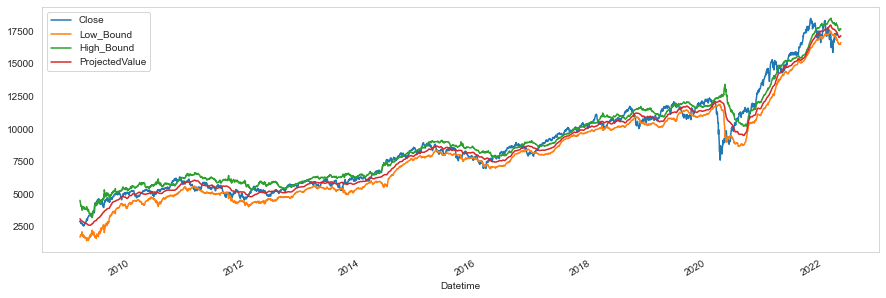

In [210]:
data[["Close", "Low_Bound", "High_Bound","ProjectedValue", "Datetime"]].set_index("Datetime").plot()
plt.show()

Optimiser

In [211]:
from Utils.utils import frange
from Optimisers.Optimiser import Optimiser

In [220]:
#Min ( (price(t) - prediction_high(t-30)), (-price(t) + prediction_low(t-30))
def goodness_of_fit(df):
    df["High_Bound"] = df["High_Bound"].shift(-21)
    df["Low_Bound"] = df["Low_Bound"].shift(-21)
    df["Metric"] = np.minimum(df["Close"]-df["High_Bound"], df["Low_Bound"]-df["Close"])
    return df["Metric"].sum()

In [226]:
params_searchspace = {
    "Hurst_Lookback": frange(100,1000,100),
    "PredictionModelLookback": frange(10,100,10),
    "Arima_p": [None],
    "Arima_d": [None],
    "Arima_q": [None],
    "smoothinglookback": frange(100,1000,100),
    "multiplier": frange(1,20,1)
}
params_searchspace = [params_searchspace[key] for key in params_searchspace.keys()]

In [ ]:
optimiser = Optimiser(method="BruteForce")
optimiser.define_parameter_searchspace(params_searchspace)
optimiser.import_data(df)
optimiser.define_alpha_function(test)
optimiser.define_optim_function(goodness_of_fit)
results = optimiser.optimise(parallelize=False)

 34%|███▍      | 4721/13851 [23:50:19<89:43:10, 35.38s/it]

DF1:
Dataframe -> Col1:Campaign Col2:ID

DF2 -> Index:ID, Col1: Campaign1, Col2: Campaign2......., Coln: CampaignN

In [ ]:
#Loopthrough each cell in df2:
for i in range(len(df2)):
    for col in df2.columns:
        id = df2.iloc[i].index
        campaign = col
        #find all entries with campaign name in df1
        df = df1[df1["Campaign"]==campaign]
        flag = 0
        #check if corresponding id is present in df1
        for k in range(len(df)):
            if df.iloc[k]["ID"] == id:
                flag=1
        if flag==1:
            df2.loc[id, campaign] = "Yes"
        else:
            df2.loc[id, campaign] = "No"
